1. Import & Path

In [1]:
from pathlib import Path
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy import stats

INT  = Path("data/interim")
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables"); TBL.mkdir(parents=True, exist_ok=True) 

2. Load Returns

In [2]:
ret_path = PROC / "monthly_returns_gold_btc_2020_2025.csv"
if ret_path.exists():
    ret = pd.read_csv(ret_path, parse_dates=["Date"]).set_index("Date").sort_index()
else:
    # fallback recalculate from merged
    merged = pd.read_csv(INT/"merged_gold_btc_monthly_2020_2025.csv", parse_dates=["Date"]).set_index("Date").sort_index()
    merged.index = merged.index.to_period("M").to_timestamp("M")
    ret = merged.assign(
        Gold_ret = np.log(merged["Gold_USD"]).diff(),
        BTC_ret  = np.log(merged["BTC_USD"]).diff()
    ).dropna(subset=["Gold_ret","BTC_ret"])

n = len(ret)
print("Observation (months):", n, "| Range:", ret.index.min().date(), "->", ret.index.max().date())
assert n >= 12, "Too little observation for rolling windows. Check the previous step."
ret.head()

Observation (months): 66 | Range: 2020-02-29 -> 2025-07-31


,Gold_USD,BTC_USD,Gold_ret,BTC_ret
Date,,,,
2020-02-29,1597.10,8545.45,0.023074,-0.089146
2020-03-31,1591.93,6423.61,-0.003242,-0.285419
2020-04-30,1683.17,8637.56,0.055732,0.296140
2020-05-31,1715.91,9450.47,0.019265,0.089944
2020-06-30,1732.22,9136.47,0.009460,-0.033790


3. Full Correlation + p-value + 95% Confidence Interval (CI)

In [3]:
r, p = stats.pearsonr(ret["Gold_ret"], ret["BTC_ret"])

# Fisher r-to-z CI
z = np.arctanh(np.clip(r, -0.999999, 0.999999))
se = 1/np.sqrt(n-3)
z_lo, z_hi = z - 1.96*se, z + 1.96*se
ci_lo, ci_hi = np.tanh([z_lo, z_hi])

summary_full = pd.DataFrame([{
    "n_months": n,
    "pearson_r": r,
    "p_value": p,
    "ci95_lo": ci_lo,
    "ci95_hi": ci_hi
}]).round(6)

summary_full.to_csv(TBL/"correlation_fullperiod.csv", index=False)
print(summary_full)
print("Saved ->", (TBL/"correlation_fullperiod.csv").resolve())

   n_months  pearson_r   p_value   ci95_lo   ci95_hi
0        66  -0.068609  0.584116 -0.305572  0.176356
Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\correlation_fullperiod.csv


4. Rolling Correlation (6M & 12M) + Save Chart

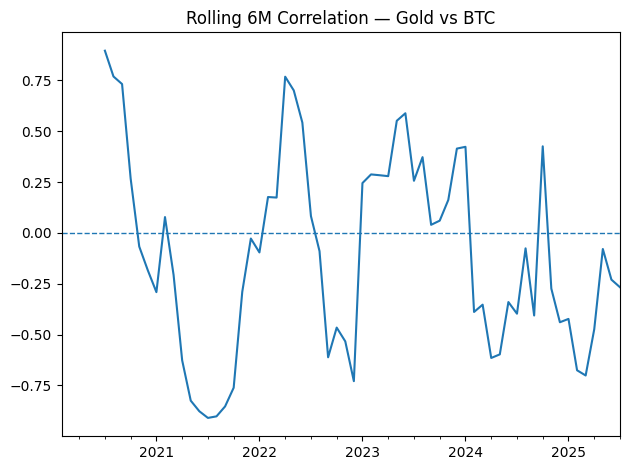

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\rolling_corr_6M.png


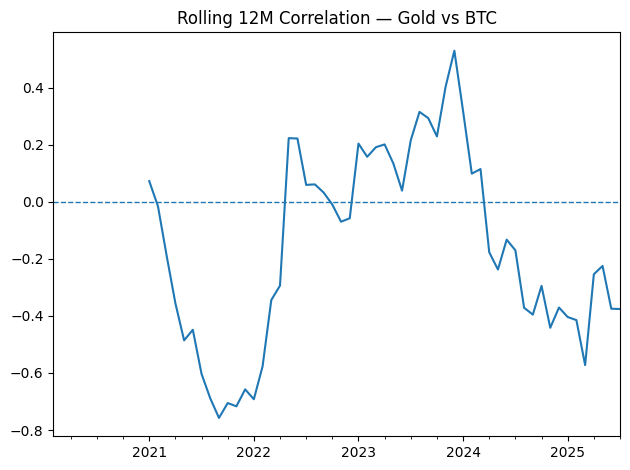

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\rolling_corr_12M.png


In [4]:
roll6  = ret["Gold_ret"].rolling(6).corr(ret["BTC_ret"])
roll12 = ret["Gold_ret"].rolling(12).corr(ret["BTC_ret"])

# 6 months
ax = roll6.plot(title="Rolling 6M Correlation — Gold vs BTC")
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_xlabel(""); plt.tight_layout()
plt.savefig(FIG/"rolling_corr_6M.png", dpi=140); plt.show()
print("Saved ->", (FIG/"rolling_corr_6M.png").resolve())

# 12 months
ax = roll12.plot(title="Rolling 12M Correlation — Gold vs BTC")
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_xlabel(""); plt.tight_layout()
plt.savefig(FIG/"rolling_corr_12M.png", dpi=140); plt.show()
print("Saved ->", (FIG/"rolling_corr_12M.png").resolve())


5. Rolling Metrics Summary + Export

In [5]:
def frac_neg(x):
    x = x.dropna()
    return 0.0 if len(x)==0 else (x.lt(0).sum()/len(x))

summary_roll = pd.DataFrame({
    "roll6_mean": [roll6.mean()],
    "roll6_min": [roll6.min()],
    "roll6_max": [roll6.max()],
    "roll6_frac_neg": [frac_neg(roll6)],
    "roll12_mean": [roll12.mean()],
    "roll12_min": [roll12.min()],
    "roll12_max": [roll12.max()],
    "roll12_frac_neg": [frac_neg(roll12)],
}).round(6)

summary_roll.to_csv(TBL/"correlation_rolling_summary.csv", index=False)
print(summary_roll)
print("Saved ->", (TBL/"correlation_rolling_summary.csv").resolve())

   roll6_mean  roll6_min  roll6_max  roll6_frac_neg  roll12_mean  roll12_min  \
0    -0.10627  -0.909467   0.896501        0.590164    -0.159116   -0.757553   

   roll12_max  roll12_frac_neg  
0    0.530145         0.618182  
Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\correlation_rolling_summary.csv


6. Sub-period

In [6]:
bins = [("2020-01","2021-12"), ("2022-01","2023-12"), ("2024-01","2025-12")]
rows = []
for a,b in bins:
    sub = ret.loc[a:b, ["Gold_ret","BTC_ret"]].dropna()
    if len(sub) >= 3:
        r_sub, p_sub = stats.pearsonr(sub["Gold_ret"], sub["BTC_ret"])
        rows.append({"period": f"{a}→{b}", "n": len(sub), "r": r_sub, "p_value": p_sub})
    else:
        rows.append({"period": f"{a}→{b}", "n": len(sub), "r": np.nan, "p_value": np.nan})

subtab = pd.DataFrame(rows).round(6)
subtab.to_csv(TBL/"correlation_by_subperiod.csv", index=False)
subtab


,period,n,r,p_value
0,2020-01→2021-12,23,-0.217657,0.318443
1,2022-01→2023-12,24,0.211551,0.321027
2,2024-01→2025-12,19,-0.361812,0.127972
